In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
img_root = './HDR-master/test_image/1'
img_names = ['DSC_0765.JPG', 'DSC_0766.JPG', 'DSC_0767.JPG', \
             'DSC_0768.JPG', 'DSC_0769.JPG', 'DSC_0770.JPG', \
             'DSC_0771.JPG', 'DSC_0772.JPG', 'DSC_0773.JPG', \
             'DSC_0774.JPG']

N = 50
l = 10

In [3]:
def getExif(img_path, tag):
    img = Image.open(img_path)
    exifdata = img.getexif()
    for tag_id in exifdata:
        tag_name = TAGS.get(tag_id, tag_id)
        if tag_name == tag:
            data = exifdata.get(tag_id)
            if isinstance(data, bytes):
                data = data.decode()
            return data
    return None

In [4]:
src_imgs = []
for img_name in img_names:
    src_img = cv2.imread(os.path.join(img_root, img_name))
    src_imgs.append(src_img)

In [5]:
exposure_times = []
for img_name in img_names:
    exposure_time = getExif(os.path.join(img_root, img_name), "ExposureTime")
    exposure_times.append(float(exposure_time))

In [6]:
def gsolve(Z, B, l, w):
    n = 256
    N, P = Z.shape[:2]
    
    A = np.zeros([N*P+n+1, n+N])
    b = np.zeros([A.shape[0], 1])
    
    # include the data-fitting equations
    k = 0
    for i in range(N):
        for j in range(P):
            wij = w[Z[i, j]]
            A[k, Z[i, j]] = wij
            A[k, n+i] = -wij
            b[k, 0] = wij * B[j]
            k = k + 1
    
    # fix the curve by setting its middle value to 0
    A[k, 127] = 1
    k = k + 1
    
    # include the smoothness equations
    for i in range(n-2):
        A[k, i] = l * w[i+1]
        A[k, i+1] = -2 * l * w[i+1]
        A[k, i+2] = l * w[i+1]
        k = k + 1
    
    # solve the system using SVD
    x = np.linalg.lstsq(A, b)[0]
    g = x[:n]
    lE = x[n+1:]
    
    return g, lE

In [7]:
def genlE(Z, B, g, w):
    P, height, width = Z.shape
    Z = Z.reshape([P, -1])
    lE = np.zeros([height * width]);
    for i in range(Z.shape[1]):
        n, d = 0, 0
        for j in range(P):
            z = Z[j][i]
            n += w[z] * (g[z] - B[j])
            d += w[z]
        lE[i] = n / d if d > 0 else n
    lE = lE.reshape([height, width])
    return lE

In [8]:
height, width = src_imgs[0].shape[:2]
sample_index = np.random.randint(min(height, width), size=(N, 2))

In [9]:
Z = np.zeros([N, len(src_imgs), 3])
for i in range(N):
    for j in range(len(src_imgs)):
        Z[i][j] = src_imgs[j][sample_index[i][0], sample_index[i][1]]
Z = Z.astype(int)

w = np.zeros([256])
for i in range(256):
    if i <= 127:
        w[i] = i
    else:
        w[i] = 255 - i

## Calculate R Channel

In [10]:
Z_r = Z[:, :, 2]
g_r, _ = gsolve(Z_r, np.log(exposure_times), l, w)

c:\users\yiting\anaconda3\envs\3dcv\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Calculate G Channel

In [11]:
Z_g = Z[:, :, 1]
g_g, _ = gsolve(Z_g, np.log(exposure_times), l, w)

c:\users\yiting\anaconda3\envs\3dcv\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Calculate B Channel

In [12]:
Z_b = Z[:, :, 0]
g_b, _ = gsolve(Z_b, np.log(exposure_times), l, w)

c:\users\yiting\anaconda3\envs\3dcv\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Plot Curves

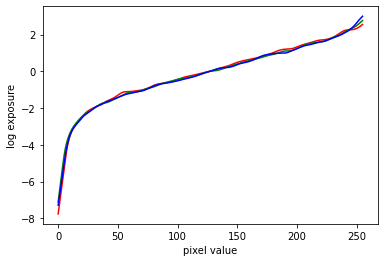

In [13]:
x_axis = [i for i in range(0, 256)]
plt.figure()
plt.plot(x_axis, g_r, label='r channel', color='r')
plt.plot(x_axis, g_g, label='g channel', color='g')
plt.plot(x_axis, g_b, label='b channel', color='b')
plt.xlabel('pixel value')
plt.ylabel('log exposure')
plt.show()

## Generate HDR Image

In [14]:
imgs = np.array(src_imgs)
Z_r = imgs[:, :, :, 2]
lE_r = genlE(Z_r.copy(), np.log(exposure_times), g_r, w)

In [15]:
Z_g = imgs[:, :, :, 1]
lE_g = genlE(Z_g.copy(), np.log(exposure_times), g_g, w)

In [16]:
Z_b = imgs[:, :, :, 0]
lE_b = genlE(Z_b.copy(), np.log(exposure_times), g_b, w)

In [17]:
E = np.zeros([height, width, 3])
E[:, :, 0] = lE_b
E[:, :, 1] = lE_g
E[:, :, 2] = lE_r
E = np.exp(E)

Text(0.5, 1.0, 'Radiance Map')

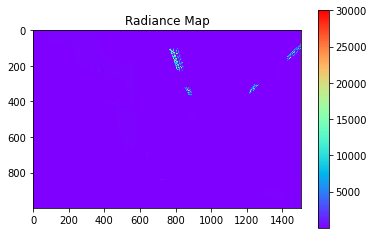

In [18]:
plt.imshow(E[:, :, 0], origin="lower", cmap='rainbow', interpolation='nearest')
# plt.clim(np.min(E[:, :, 0]), 1000)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Radiance Map")

In [19]:
cv2.imwrite('./output/1.hdr', E)

True

## Tone Mapping

In [55]:
def gaussian(x, sig):
    return np.exp(-np.power(x, 2.) / (2 * np.power(sig, 2.))) * (1.0 / (2 * np.pi * (sig ** 2)))

In [74]:
def output_rescale_all(image, origin_images, W):
    b, g, r = cv2.split(image)
    mean_image = np.zeros((image.shape[0], image.shape[1], 3))
    print("------------ rescaling output ------------")
    for i in tqdm(range(image.shape[0])):
        for j in range(image.shape[1]):
            for k in range(3):
                wsum = 0
                pixelvalue = 0
                for l in range(len(origin_images)):
                    w = W[origin_images[l][i, j, k]]
                    pixelvalue += w * origin_images[l][i, j, k]
                    wsum += w
                mean_image[i, j, k] = pixelvalue / wsum
    b2, g2, r2 = cv2.split(mean_image)
    b *= np.nanmean(b2) / np.nanmean(b)
    g *= np.nanmean(g2) / np.nanmean(g)
    r *= np.nanmean(r2) / np.nanmean(r)
    image = cv2.merge((b,g,r))
    return image

In [57]:
def bilateral_filter(log_intensity, x, y, filter_size=5):
    k = 0
    output = 0
    sigma_g = 2000
    sigma_f = 1000
    for i in range(filter_size):
        for j in range(filter_size):
            movei = i - filter_size // 2
            movej = j - filter_size // 2
            if x + movei >= log_intensity.shape[0] or x + movei < 0 or y + movej >= log_intensity.shape[1] or y + movej < 0:
                continue
            f = gaussian(np.sqrt(movei ** 2 + movej ** 2), sigma_f)
            g = gaussian(log_intensity[x][y] - log_intensity[x + movei][y + movej], sigma_g)
            k += f * g
            output += f * g * log_intensity[x + movei][y + movej]
    output = output/k
    return output

In [58]:
def bilateral(img, compression=0.8):
    intensity = 0.0722*img[:, :, 0] + 0.7152*img[:, :, 1] + 0.2126*img[:, :, 2]
    log_intensity = np.log(intensity)
    log_large_scale = np.zeros(log_intensity.shape)
    print("------------ tone mapping ------------")
    for i in tqdm(range(log_large_scale.shape[0])):
        for j in range(log_large_scale.shape[1]):
            log_large_scale[i, j] = bilateral_filter(log_intensity, i, j)
    log_detail = log_intensity - log_large_scale
    log_output = log_large_scale * compression + log_detail
    output = np.zeros((img.shape[0], img.shape[1], 3))
    output[:, :, 0] = img[:, :, 0]/intensity * np.exp(log_output)
    output[:, :, 1] = img[:, :, 1]/intensity * np.exp(log_output)
    output[:, :, 2] = img[:, :, 2]/intensity * np.exp(log_output)
    return output

In [59]:
output = bilateral(E)
for i in range(3):
    output[:, :, i] = cv2.normalize(output[:, :, i], np.array([]), alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

------------ tone mapping ------------


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:28<00:00,  2.57it/s]


In [75]:
outputimg = output_rescale_all(output, src_imgs, w)

  0%|▍                                                                                | 5/1000 [00:00<00:24, 41.25it/s]

------------ rescaling output ------------


  9%|███████▏                                                                        | 90/1000 [00:02<00:22, 40.64it/s]c:\users\yiting\anaconda3\envs\3dcv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.70it/s]


In [78]:
cv2.imshow('tonemapping', outputimg/255)
cv2.waitKey(0)

-1

In [79]:
cv2.imwrite('output/1.png', outputimg)

True

In [49]:
# def durand_bilateral(hdr):
#     ldr = np.zeros_like(hdr)

#     b, g, r = 1, 40, 20

#     Lw = (hdr[:, :, 0] * b + hdr[:, :, 1] * g + hdr[:, :, 2] * r) / (b + g + r)
#     log_Lw = np.log10(Lw)
#     log_base = cv2.bilateralFilter(log_Lw, 5, 15, 15)
#     log_detail = log_Lw - log_base

#     cf = np.log10(5) / (np.max(log_base) - np.min(log_base)) # compression factor
#     log_absolute_scale = np.max(log_base) * cf
#     log_Ld = log_base*cf + log_detail - log_absolute_scale
#     Ld = np.power(10, log_Ld)

#     ldr[:, :, 0] = (hdr[:, :, 0] / Lw) * Ld
#     ldr[:, :, 1] = (hdr[:, :, 1] / Lw) * Ld
#     ldr[:, :, 2] = (hdr[:, :, 2] / Lw) * Ld

#     ldr = np.clip((ldr ** 0.3) * 255, 0, 255)

#     return ldr.astype(np.uint8)

In [50]:
# ldr = durand_bilateral(E.astype(np.float32))

In [51]:
# cv2.imshow('ldr', ldr)
# cv2.waitKey(0)

-1

# Test OpenCV Tone Mapping Function

In [18]:
def toneMappingReinhard(hdrImg):
    tonemapReinhard = cv2.createTonemapReinhard(0.9,4,1,0) # gama, intensity, light_adapt, color_adapt
    ldrReinhard = tonemapReinhard.process(hdrImg)
    # Plot hdr images
    ldrReinhard_rgb=ldrReinhard[:,:,::-1]
    #fig5=plt.figure().suptitle('tone-mapped HDR image')
    #plt.imshow(ldrReinhard_rgb)
    subfig = plt.subplot(2,2,3)
    subfig.set_title("Reinhard")
    subfig.imshow(ldrReinhard_rgb)
    return ldrReinhard

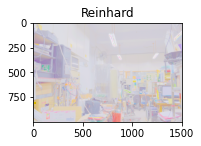

In [22]:
img = toneMappingReinhard(E.astype(np.float32))